# Introduction

Baseline two-staged models

- CV (1 fold for now)
    - Train for I stage models (2 weeks)
    - Train for II stage models, valid for II stage model (2 weeks)
    - Test for I and II stage models.
- Take all products, repeats too.

Choice of models:
- I stage models
    - Popularity
    - Buy together - ItemKNN for interaction matrix.
    - Have touch in any possible way.
- II stage model
    - User - item interaction features.
 
Expected results:

USER_ID, ITEM_ID, features of interactions, scores of I stage models.
 
### Imports

In [1]:
import git
root = git.Repo('.', search_parent_directories=True).working_dir 

import polars as pl

import seaborn as sns

# Data Loading

In [2]:
tracker = pl.scan_parquet(f'{root}/data/tracker')
order = pl.scan_parquet(f'{root}/data/orders')
test_df = pl.scan_parquet(f'{root}/data/test/')

# Date Split

In [3]:
first_stage_start, first_stage_end = pl.datetime(2025, 5, 1), pl.datetime(2025, 5, 14)
second_stage_start, second_stage_end = pl.datetime(2025, 5, 15), pl.datetime(2025, 5, 28)
test_stage_start, test_stage_end = pl.datetime(2025, 5, 28), pl.datetime(2025, 6, 11)

# Second Stage Models Features

In [4]:
first_order = (
    order
    .filter(
        pl.col('last_status_timestamp').is_between(first_stage_start, first_stage_end)
    )
    .select('user_id', 'item_id', 'last_status')
    .rename({'last_status': 'action_type'})
)

first_tracker = (
    tracker
    .filter(
        pl.col('timestamp').is_between(first_stage_start, first_stage_end)
    )
    .select('user_id', 'item_id', 'action_type')
)

first_df = pl.concat([first_tracker, first_order])
first_df.collect_schema()

Schema([('user_id', Int32), ('item_id', Int32), ('action_type', String)])

In [5]:
action_types = first_df.select('action_type').unique().collect().to_numpy().squeeze()
action_types

array(['to_cart', 'canceled_orders', 'delivered_orders',
       'view_description', 'proccesed_orders', 'unfavorite', 'favorite',
       'remove', 'review_view', 'page_view'], dtype=object)

In [6]:
action_counts = [
    pl.col("action_type")
    .filter(pl.col("action_type") == at)
    .count()
    .alias(at)
    .cast(pl.Int16)
    for at in action_types
]

features = (
    first_tracker
    .group_by(["user_id", "item_id"])
    .agg(*action_counts)
)

features = features.collect()

print(features.shape)
features.head()

(64026910, 12)


user_id,item_id,to_cart,canceled_orders,delivered_orders,view_description,proccesed_orders,unfavorite,favorite,remove,review_view,page_view
i32,i32,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16
1282500,84819114,0,0,0,0,0,0,0,0,0,1
136091,106767407,0,0,0,0,0,0,0,0,0,1
3706501,168219970,0,0,0,0,0,0,0,0,0,2
4740861,161537459,0,0,0,0,0,0,0,0,0,1
4440800,183835221,0,0,0,0,0,1,0,0,0,1


# I Stage model - touch with item_id

In [7]:
def get_count_of_recommendations(df):

    n_products = df.group_by('user_id').agg(pl.len()).select(pl.col('len').alias('n_products')).to_pandas()
    return n_products.value_counts().sort_index()

In [8]:
touch_first_stage = features.select(['user_id', 'item_id'])
get_count_of_recommendations(touch_first_stage)

n_products
1             46343
2             32759
3             26804
4             23341
5             20745
              ...  
5732              1
5793              1
5881              1
6175              1
6242              1
Name: count, Length: 1914, dtype: int64

In [9]:
touch_first_stage = touch_first_stage.group_by('user_id').head(100)
get_count_of_recommendations(touch_first_stage)

n_products
1              46343
2              32759
3              26804
4              23341
5              20745
               ...  
96              1828
97              1871
98              1828
99              1788
100           184917
Name: count, Length: 100, dtype: int64

In [10]:
touch_first_stage.shape

(36378765, 2)

- Limit number of combinations per user at random

# I stage model - popular products

In [11]:
popular_first_stage = (
    first_order
    .group_by('item_id')
    .agg(pl.len())
    .sort('len', descending=False)
    .head(10)
    .select('item_id')
    .collect()
)

In [12]:
(
    touch_first_stage
    .with_columns(
        pl.col('item_id').is_in(popular_first_stage.to_numpy().squeeze()).alias('is_popular')
    )
    .select('is_popular')
    .mean()
)

is_popular
f64
0.000004


- Popular ordered products have small intersection with user-specific actions

# I Stage Model validation

In [13]:
second_order = (
    order
    .filter(
        pl.col('last_status_timestamp').is_between(second_stage_start, second_stage_end) &
        ~pl.col('last_status').is_in(['canceled_orders'])
    )
    .select('user_id', 'item_id', pl.lit(1).alias('selected'))
    .collect()
)

print(second_order.shape)
second_order.head()

(867715, 3)


user_id,item_id,selected
i32,i32,i32
3470100,119241,1
3612281,319008,1
2592401,602129,1
1622171,1127352,1
1434171,1196268,1


In [14]:
second_candidates = pl.concat([
    second_order.select('user_id').unique().join(touch_first_stage, how='inner', on='user_id'),
    second_order.select('user_id').unique().join(popular_first_stage, how='cross')
]).unique().with_columns(pl.lit(1).alias('is_candidate'))

print(second_candidates.shape)

second_candidates

(22897557, 3)


user_id,item_id,is_candidate
i32,i32,i32
2557850,62458138,1
1846410,197829721,1
795780,107991452,1
4994531,259270796,1
172850,320163036,1
…,…,…
4883910,329437519,1
2730730,137410047,1
1438631,283152300,1


In [15]:
first_recall = second_order.join(second_candidates, how='left', on=['user_id', 'item_id']).fill_null(0)

first_recall.head(5)

user_id,item_id,selected,is_candidate
i32,i32,i32,i32
3470100,119241,1,0
3612281,319008,1,0
2592401,602129,1,0
1622171,1127352,1,0
1434171,1196268,1,1


In [16]:
first_recall.select(pl.mean('is_candidate'))

is_candidate
f64
0.24557


- Popular product give no gain over item_ids with some user_action

<Axes: xlabel='is_candidate', ylabel='Count'>

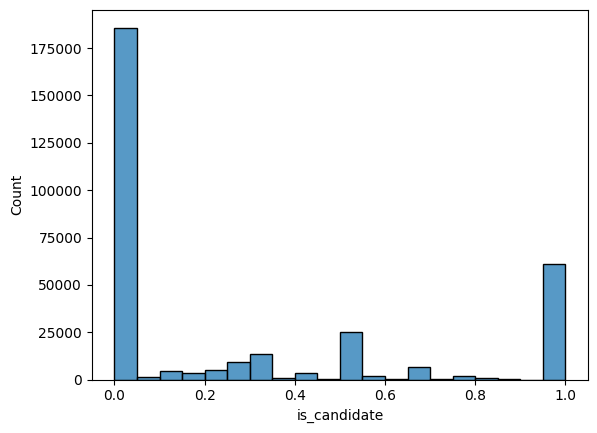

In [17]:
is_candidate = first_recall.group_by('user_id').agg(pl.mean('is_candidate')).select('is_candidate').to_pandas()
sns.histplot(is_candidate['is_candidate'], binwidth=0.05)

# II Stage Model Learning

In [18]:
second_stage_target = second_candidates.join(second_order, how='left', on=['user_id', 'item_id']).fill_null(0)
second_stage_target = second_stage_target.select('user_id', 'item_id', 'selected').filter(pl.sum('selected').over(['user_id']) > 0)
second_stage_target.head()

user_id,item_id,selected
i32,i32,i32
2557850,62458138,0
1846410,197829721,0
172850,320163036,0
4074520,98207412,0
3133631,163204063,0


In [19]:
second_stage_df = second_stage_target.join(features, how='left', on=['user_id', 'item_id'])

In [20]:
import lightgbm as lgb

In [21]:
second_stage_df = second_stage_df.sort('user_id')
second_stage_df

user_id,item_id,selected,to_cart,canceled_orders,delivered_orders,view_description,proccesed_orders,unfavorite,favorite,remove,review_view,page_view
i32,i32,i32,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16
30,25117760,0,0,0,0,1,0,0,0,0,0,1
30,193241077,0,0,0,0,0,0,0,0,0,0,1
30,3612686,0,0,0,0,0,0,1,0,0,0,0
30,282606532,0,0,0,0,1,0,0,1,0,0,1
30,153370562,0,0,0,0,0,0,0,1,1,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…
5061651,144578163,0,null,null,null,null,null,null,null,null,null,null
5061651,82192656,0,null,null,null,null,null,null,null,null,null,null
5061651,60042389,0,0,0,0,0,0,0,0,0,0,1


In [22]:
groups = second_stage_df.select('user_id').to_pandas()
groups = groups.user_id.value_counts().loc[groups.user_id.unique()].values

In [23]:
# Create LightGBM Dataset for ranking
train_data = lgb.Dataset(
    second_stage_df.drop('selected', 'item_id', 'user_id').to_pandas(), 
    label=second_stage_df.select('selected').to_pandas().squeeze(), 
    group=groups
)

In [24]:
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'ndcg_eval_at': [5, 10],
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbosity': -1,
    'random_state': 42,
    'force_row_wise': True
}

# Train the model
print("Training LightGBM Ranker...")
model = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[train_data],
    valid_names=['train'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=10, verbose=True),
        lgb.log_evaluation(period=10)
    ]
)


Training LightGBM Ranker...
Training until validation scores don't improve for 10 rounds
[10]	train's ndcg@5: 0.513721	train's ndcg@10: 0.564791
[20]	train's ndcg@5: 0.514029	train's ndcg@10: 0.565292
[30]	train's ndcg@5: 0.514338	train's ndcg@10: 0.565546
[40]	train's ndcg@5: 0.514625	train's ndcg@10: 0.565747
[50]	train's ndcg@5: 0.515054	train's ndcg@10: 0.566154
[60]	train's ndcg@5: 0.515297	train's ndcg@10: 0.56628
[70]	train's ndcg@5: 0.515492	train's ndcg@10: 0.566444
[80]	train's ndcg@5: 0.51552	train's ndcg@10: 0.566462
[90]	train's ndcg@5: 0.515694	train's ndcg@10: 0.56668
[100]	train's ndcg@5: 0.515709	train's ndcg@10: 0.566731


# I and II stage models evaluation

In [29]:
second_tracker = (
    tracker
    .filter(
        pl.col('timestamp').is_between(second_stage_start, second_stage_end)
    )
    .select('user_id', 'item_id', 'action_type')
)

second_df = pl.concat([second_tracker, second_order])
second_df.collect_schema()

Schema([('user_id', Int32), ('item_id', Int32), ('action_type', String)])

In [31]:
features = (
    second_tracker
    .group_by(["user_id", "item_id"])
    .agg(*action_counts)
)

features = features.collect()

print(features.shape)
features.head()

(64310435, 12)


user_id,item_id,to_cart,canceled_orders,delivered_orders,view_description,proccesed_orders,unfavorite,favorite,remove,review_view,page_view
i32,i32,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16
4018251,327540502,0,0,0,0,0,0,1,0,0,2
2963900,20607894,0,0,0,0,0,0,0,0,0,1
2462961,10049982,1,0,0,0,0,0,0,0,0,1
53771,202050919,0,0,0,0,0,0,0,0,0,1
3515511,337576766,1,0,0,0,0,0,0,1,0,3


In [32]:
touch_second_stage = features.select(['user_id', 'item_id'])
touch_second_stage = touch_second_stage.group_by('user_id').head(100)
get_count_of_recommendations(touch_second_stage)

n_products
1              45994
2              32429
3              26629
4              23004
5              20489
               ...  
96              1969
97              1835
98              1860
99              1842
100           188446
Name: count, Length: 100, dtype: int64

In [33]:
popular_second_stage = (
    second_order
    .group_by('item_id')
    .agg(pl.len())
    .sort('len', descending=False)
    .head(10)
    .select('item_id')
    .collect()
)

# Submit

In [37]:
submit_candidates = pl.concat([
    test_df.select('user_id').collect().unique().join(touch_second_stage, how='inner', on='user_id'),
    test_df.select('user_id').collect().unique().join(popular_second_stage, how='cross')
]).unique().with_columns(pl.lit(1).alias('is_candidate'))

print(submit_candidates.shape)

submit_candidates

(30623165, 3)


user_id,item_id,is_candidate
i32,i32,i32
3470560,129046002,1
30951,171512205,1
4854080,242700654,1
4139401,65964830,1
1926950,329432914,1
…,…,…
876651,244727712,1
4526340,2048076,1
2113831,273324409,1


In [39]:
submit_candidates.select('user_id').unique().count()

user_id
u32
470347


In [42]:
submit_candidates = submit_candidates.join(features, how='left', on=['user_id', 'item_id']).drop('is_candidate')

In [47]:
predict = model.predict(submit_candidates.drop('user_id', 'item_id').to_pandas())

In [49]:
predict

array([-2.19065677, -2.19065677, -1.35026858, ..., -1.60696823,
       -2.19065677, -2.19065677], shape=(30623165,))

In [50]:
submit_candidates = submit_candidates.to_pandas()[['user_id', 'item_id']]

In [51]:
submit_candidates['rank'] = predict

In [54]:
submit_candidates

,user_id,item_id,rank
0,3470560,129046002,-2.190657
1,30951,171512205,-2.190657
2,4854080,242700654,-1.350269
3,4139401,65964830,1.375074
4,1926950,329432914,-2.190657
...,...,...,...
30623160,876651,244727712,-2.190657
30623161,4526340,2048076,-2.190657
30623162,2113831,273324409,-1.606968
30623163,98850,119570884,-2.190657


In [56]:
popular_second_stage_2 = (
    second_order
    .group_by('item_id')
    .agg(pl.len())
    .sort('len', descending=False)
    .head(90)
    .select('item_id')
    .collect()
    .to_pandas()
)

In [60]:
t = submit_candidates.user_id.drop_duplicates().to_frame().merge(popular_second_stage_2, how='cross')

In [61]:
t['rank'] = -1000

In [64]:
import pandas as pd
submit_candidates = pd.concat([submit_candidates, t], axis=0).drop_duplicates(['user_id', 'item_id'])

In [67]:
submit_candidates = submit_candidates.sort_values('rank', ascending=False)
submit_candidates

,user_id,item_id,rank
20635979,1553340,117904004,2.877221
8286416,4391690,209536661,2.841210
1544563,954311,217373252,2.841210
24559165,188911,313016951,2.838752
27949505,389741,255651911,2.820087
...,...,...,...
42331205,2123341,237499658,-1000.000000
42331204,2123341,206383412,-1000.000000
42331203,2123341,155036489,-1000.000000
42331202,2123341,45489338,-1000.000000


In [68]:
submit_candidates['rank'] = submit_candidates.groupby('user_id')['rank'].cumcount() + 1

In [70]:
submit_candidates = submit_candidates[submit_candidates['rank'] <= 100]

In [74]:
submit_candidates = submit_candidates.pivot(index='user_id', columns='rank', values='item_id').add_prefix('item_')

In [78]:
submit_candidates.isna().sum().sum()

np.int64(0)

In [95]:
submit_candidates.reset_index().to_csv('submit.csv', index=False)

In [79]:
submit_candidates.columns = [col.replace('item_', 'item_id_') for col in submit_candidates.columns]

In [96]:
pd.read_csv('submit.csv')

,user_id,item_id_1 item_id_2 ... item_id_100
0,1,336690475 177008489 42233071 140634651 2530228...
1,21,79922208 159181556 279061554 326764295 3182952...
2,30,134503837 77696741 246144687 124317721 3186026...
3,51,178891818 339048267 101716501 178256080 293554...
4,60,12689999 272126064 16276305 144159576 30491321...
...,...,...
470342,5061670,244670908 242694214 265449407 181176782 158661...
470343,5061671,124842086 300587813 87874269 331283434 1899466...
470344,5061680,80859188 59617342 281575404 30493479 71049829 ...
470345,5061681,176591826 326280438 33260658 252810202 3496328...


In [85]:
submit_candidates['item_id_1 item_id_2 ... item_id_100'] = submit_candidates.astype(str).agg(" ".join, axis=1)

In [86]:
submit_candidates = submit_candidates[['item_id_1 item_id_2 ... item_id_100']]

In [91]:
len(submit_candidates.iloc[0, 0].split(' '))

100